In [159]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, KFold

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
import xgboost 
import time

In [172]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Date and EDA

In [80]:
avg_df = pd.read_csv('data/Средняя масса доли АПГ New.csv')
min3_df = pd.read_csv('data/3min_series.csv')
target = pd.read_csv('data/target.csv', sep=';')

In [81]:
avg_df.shape , min3_df.shape , target.shape

((2028, 2), (52269, 19), (166, 2))

In [82]:
avg_df.head()

,Dateparse,avg_mass_apg
0,30-Jul-18 23:00:00,0.50
1,31-Jul-18 00:00:00,0.51
2,31-Jul-18 01:00:00,0.51
3,31-Jul-18 02:00:00,0.51
4,31-Jul-18 03:00:00,0.51


In [83]:
avg_df.tail()

,Dateparse,avg_mass_apg
2023,23-Oct-18 06:00:00,0.494167
2024,23-Oct-18 07:00:00,0.494167
2025,23-Oct-18 08:00:00,0.494167
2026,23-Oct-18 09:00:00,0.494167
2027,23-Oct-18 10:00:00,0.494167


In [84]:
min3_df.sort_values(by='Date').head()

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
505,01-Aug-18 00:01:00,0.011,2.175,-1.7,6.0,268.0,337.0,309.0,284.0,406.0,382.0,370.0,376.0,342.0,370.0,331.0,333.0,281.0,263.0
506,01-Aug-18 00:04:00,0.011,2.175,-1.7,7.0,270.0,340.0,310.0,285.0,407.0,385.0,373.0,376.0,344.0,368.0,334.0,335.0,284.0,267.0
507,01-Aug-18 00:07:00,0.012,2.175,-1.8,7.0,273.0,344.0,311.0,286.0,406.0,385.0,376.0,376.0,343.0,368.0,336.0,337.0,287.0,267.0
508,01-Aug-18 00:10:00,0.012,2.175,-2.0,7.0,276.0,345.0,312.0,286.0,406.0,385.0,380.0,378.0,343.0,370.0,337.0,337.0,288.0,268.0
509,01-Aug-18 00:13:00,0.010,2.175,-1.8,6.0,277.0,345.0,312.0,287.0,407.0,386.0,380.0,377.0,343.0,370.0,336.0,336.0,288.0,267.0


In [85]:
target.head()

,Unnamed: 0,product_percents
0,2018-07-28 05:00:00,3.68
1,2018-07-28 14:00:00,3.49
2,2018-07-29 05:00:00,3.61
3,2018-07-29 14:00:00,3.65
4,2018-07-30 05:00:00,3.41


In [86]:
target.columns = ['dtime', 'product_percents']

In [87]:
# Convert to datetime format
target.dtime = pd.to_datetime(target.dtime)
min3_df.Date = pd.to_datetime(min3_df.Date)
avg_df.Dateparse = pd.to_datetime(avg_df.Dateparse)

/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


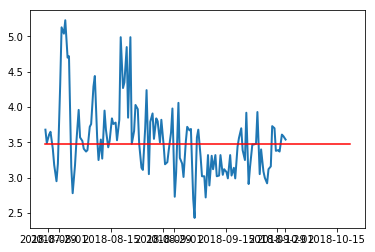

In [10]:
#Distribution by time.
plt.plot(target.dtime, target.product_percents, linewidth=2)
plt.plot(target.dtime, [target.product_percents.median()]*target.shape[0], c='r')

 In general, there are no any evident trends in time. It is more like uniform distribution.

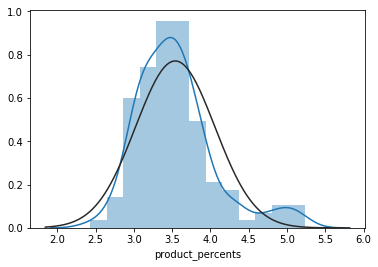

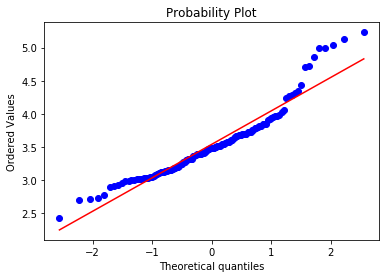

In [11]:
#histogram and normal probability plot
import scipy
from scipy.stats import norm
sns.distplot(target['product_percents'].dropna(),fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(target['product_percents'].dropna(), plot=plt)

Target distrubution like normal.

In [138]:
# for s in min3_df.columns[1:]:

#     plt.title('Probability distribution %s' %s)
#     sns.distplot(min3_df[c].fillna(min3_df[c].median()))
#     plt.show()
    
#     plt.title('Distibution %s by time' %s)
#     plt.xlabel('time')
#     plt.plot(min3_df.Date, min3_df[c])
#     plt.show()

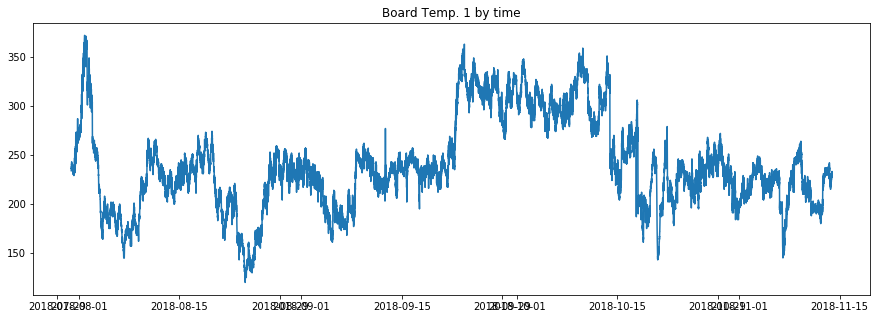

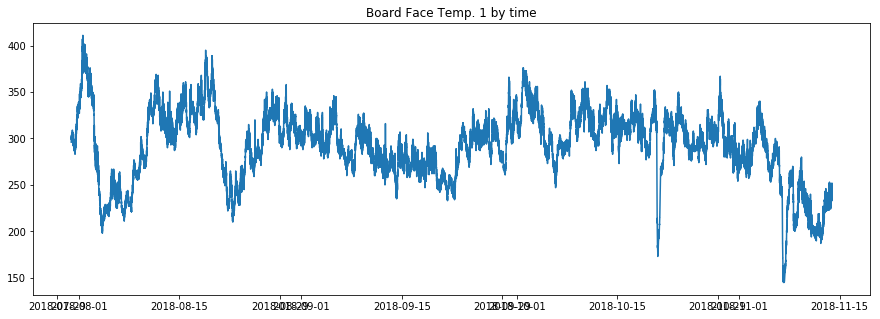

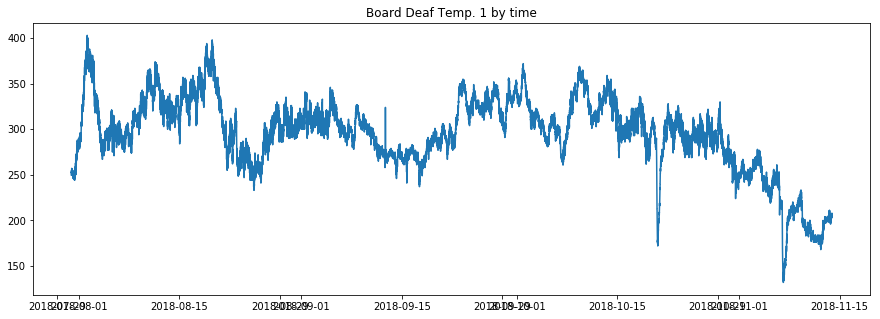

In [244]:
plt.figure(figsize=[15,5])
plt.title('Board Temp. 1 by time')
plt.plot(min3_df.Date, min3_df['Board Temp. 1'])
plt.show()
plt.figure(figsize=[15,5])
plt.title('Board Face Temp. 1 by time')
plt.plot(min3_df.Date, min3_df['Board Face Temp. 1'])
plt.show()
plt.figure(figsize=[15,5])
plt.title('Board Deaf Temp. 1 by time')
plt.plot(min3_df.Date, min3_df['Board Deaf Temp. 1'])
plt.show()

Trends in time are exists. The temperature of insight, face and deaf part of equipment have dependenses in time. The 6th too.

In [94]:
min3_df['Обратная ЭДС'] = (min3_df['Обратная ЭДС'].fillna(min3_df['Обратная ЭДС'].median())) 
min3_df['Шум'] = (min3_df['Шум'].fillna(min3_df['Шум'].median())) 

Parameters like 'Обратная ЭДС' and "Шум" which like lognormal distribution should be loged. Temperature feats are distributed simlier normal than don't need preproceccing

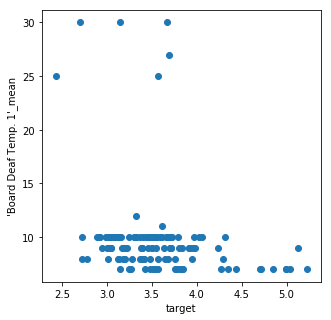

In [246]:
plt.figure(figsize=[5,5])
plt.ylabel(new_feats.columns[129])
plt.xlabel('target')
plt.scatter(target.product_percents,new_feats[new_feats.columns[129]])

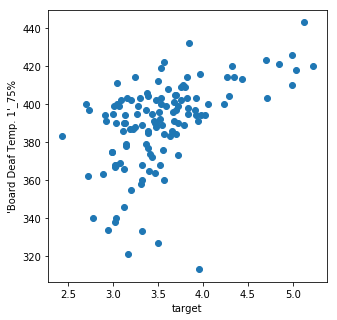

In [247]:
plt.figure(figsize=[5,5])
plt.ylabel(new_feats.columns[134])
plt.xlabel('target')
plt.scatter(target.product_percents,new_feats[new_feats.columns[134]])

Sometimes features have clear linear dependensis to target with some noise.

In [21]:
# Match target with parameters

# There are no exact comparisons of the target in the data, 
# so I assume that the data corresponding to the period between the current target and the previous one .
# Since many lines can correspond to a period, 
# I applied the statistical functions of the mean for each feature vector

new_feats = []
for i in range(target.shape[0]):
#     Don't included right threshold because it can be leak. In time of calculating target new data may 
#     not be ready

    #For first include all observations before target
    if i == 0:
        e = target.dtime.iloc[i]
        curr_3min_interval = min3_df[(min3_df.Date < e)]
        curr_avg_interval = avg_df[(avg_df.Dateparse < e)]
    #For else periods
    else:
        s = target.dtime.iloc[i-1]
        e = target.dtime.iloc[i]
    
        curr_3min_interval = min3_df[(min3_df.Date >= s) & (min3_df.Date < e)]
        curr_avg_interval = avg_df[(avg_df.Dateparse >= s) & (avg_df.Dateparse < e)]

#   Make df with new features which are matching with target 
    new_feats.append(np.concatenate([curr_3min_interval[curr_3min_interval.columns[1:]].describe(
                        ).values.reshape(1,-1),
                    curr_avg_interval[curr_avg_interval.columns[1:]].describe(
                        ).values.reshape(1,-1)], axis=1).ravel())

In [22]:
# Name for parameters
col = ['%r_%s' % (r, s) for r in curr_3min_interval.columns[1:] for s in curr_3min_interval[
            curr_3min_interval.columns[1:]].describe().index] + [ 
          'avg_mass_apg_%r' % r for r in curr_avg_interval[curr_avg_interval.columns[1:]].describe().index]

In [23]:
new_feats = pd.DataFrame(new_feats)

In [24]:
new_feats.columns = col

In [108]:
new_feats['target'] = target.product_percents

In [120]:
print('The hightest direct dependesis')
display(new_feats.corr()['target'].sort_values(ascending=False)[1:11])
print('The hightest inverse dependesis')
display(new_feats.corr()['target'].sort_values(ascending=False)[-10:])
print('The lowest dependesis')
display(new_feats.corr()['target'].sort_values(ascending=False)[70:80])

The hightest direct dependesis


'Board Deaf Temp. 6'_mean    0.554448
'Сум.доз АПГ'_50%            0.545196
'Board Face Temp. 1'_max     0.541147
'Board Temp. 7'_min          0.539733
'Board Temp. 9'_50%          0.539236
'Board Deaf Temp. 1'_50%     0.524594
'Board Temp. 5'_mean         0.517272
'Сум.доз АПГ'_mean           0.516957
'Board Face Temp. 1'_min     0.515470
'Board Deaf Temp. 1'_75%     0.511158
Name: target, dtype: float64

The hightest inverse dependesis


'Board Temp. 9'_min         -0.140517
'Сум.доз АПГ'_min           -0.143215
'Board Temp. 7'_mean        -0.172749
'Board Temp. 4'_max         -0.208807
'Board Deaf Temp. 1'_mean   -0.243801
'Board Temp. 4'_mean        -0.377938
'Board Temp. 8'_50%         -0.383018
'Board Temp. 10'_max        -0.389301
'Board Temp. 6'_min         -0.443523
'Ср.прир.напр.'_50%         -0.462825
Name: target, dtype: float64

The lowest dependesis


'Board Temp. 1'_max         0.265000
avg_mass_apg_'mean'         0.253006
'Board Temp. 6'_count       0.241368
'Board Temp. 8'_std         0.241161
'Board Deaf Temp. 6'_max    0.237069
'Board Temp. 3'_min         0.227533
avg_mass_apg_'max'          0.224128
'Board Temp. 2'_50%         0.223899
'Board Face Temp. 6'_50%    0.223843
'Board Temp. 10'_25%        0.222251
Name: target, dtype: float64

There are no clear dependesis

In [130]:
new_feats[[i for i in new_feats.columns if 'Temp' in i and 'std' in i]].mean(axis=0).sort_values()

'Board Temp. 6'_std          -2.003221
'Board Temp. 8'_std           0.010868
'Board Temp. 2'_std           6.994011
'Board Temp. 3'_std           8.731970
'Board Temp. 4'_std         227.306250
'Board Deaf Temp. 1'_std    264.506250
'Board Face Temp. 6'_std    302.679688
'Board Face Temp. 1'_std    306.606250
'Board Temp. 1'_std         308.600825
'Board Temp. 10'_std        308.662500
'Board Temp. 5'_std         315.518750
'Board Temp. 7'_std         333.493750
'Board Deaf Temp. 6'_std    333.700000
'Board Temp. 9'_std         375.409375
dtype: float64

In [124]:
for c in [i for i in min3_df.columns if 'Temp' in i]:
    min3_df[c].std()

['Board Temp. 1',
 'Board Temp. 2',
 'Board Temp. 3',
 'Board Temp. 4',
 'Board Temp. 5',
 'Board Temp. 6',
 'Board Temp. 7',
 'Board Temp. 8',
 'Board Temp. 9',
 'Board Temp. 10',
 'Board Face Temp. 1',
 'Board Face Temp. 6',
 'Board Deaf Temp. 1',
 'Board Deaf Temp. 6']

## Dataset built

In [192]:
X_train = new_feats[~target.product_percents.isna()]
X_train = X_train.fillna(X_train.median())
X_test = new_feats[target.product_percents.isna()]
y_train = target[~target.product_percents.isna()].product_percents
y_test = target[target.product_percents.isna()].product_percents

In [193]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

## Train basic models

In [173]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GB' ,GradientBoostingRegressor()))
models.append(('LGBM',LGBMRegressor()))
models.append(('XGB', xgboost.XGBRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=17)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: mae:%f (std: %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: mae:-18.635592 (std: 12.668924)
LASSO: mae:-0.160531 (std: 0.027841)
EN: mae:-0.167758 (std: 0.034647)
KNN: mae:-0.206103 (std: 0.051055)
CART: mae:-0.245894 (std: 0.076197)
SVR: mae:-0.238297 (std: 0.096151)
RandomForest: mae:-0.162877 (std: 0.036146)
GB: mae:-0.154575 (std: 0.032729)
LGBM: mae:-0.182551 (std: 0.038664)
XGB: mae:-0.161982 (std: 0.034048)


The best basic model are LASSO and XGB. But LGBM could be faster and with tunning parameters show better score.

## Modeling Stage

In [31]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

# print('Loading data...')

lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_val, y_val, reference=lgb_train)

print('Ready')

Ready


In [30]:
estimator = lgb.LGBMRegressor(num_leaves=31)

lgbm_params = {
#     'class_weight': [None, 'balanced'],
    'n_estimators': [i for i in range(100,600,100)],
    'num_leaves': list(range(20, 50, 10)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)),
    'max_depth': list(range(5, 20)),
#     'subsample_for_bin': list(range(20000, 300000, 20000)),
#     'min_child_samples': list(range(20, 200, 5)),
#     'reg_alpha': list(np.linspace(0, 1, 10)),
#     'reg_lambda': list(np.linspace(0, 1, 10)),
#     'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'objective': ['regression']
 } 

gbm = GridSearchCV(estimator, lgbm_params, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.01134967265153673, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 20, 'objective': 'regression'}


/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Starting training...
[10]	training's rmse: 0.44929	valid_1's rmse: 0.583187
[20]	training's rmse: 0.428418	valid_1's rmse: 0.564785
[30]	training's rmse: 0.410768	valid_1's rmse: 0.5496
[40]	training's rmse: 0.395927	valid_1's rmse: 0.537067
[50]	training's rmse: 0.383257	valid_1's rmse: 0.526112
[60]	training's rmse: 0.371806	valid_1's rmse: 0.516569
[70]	training's rmse: 0.361803	valid_1's rmse: 0.508648
[80]	training's rmse: 0.352886	valid_1's rmse: 0.501635
[90]	training's rmse: 0.34501	valid_1's rmse: 0.495809
[100]	training's rmse: 0.338032	valid_1's rmse: 0.490527
[110]	training's rmse: 0.331822	valid_1's rmse: 0.485921
[120]	training's rmse: 0.326287	valid_1's rmse: 0.481722
[130]	training's rmse: 0.321473	valid_1's rmse: 0.478418
[140]	training's rmse: 0.31709	valid_1's rmse: 0.475675
[150]	training's rmse: 0.312866	valid_1's rmse: 0.472637
[160]	training's rmse: 0.308707	valid_1's rmse: 0.470779
[170]	training's rmse: 0.304547	valid_1's rmse: 0.468759
[180]	training's rmse: 0

/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


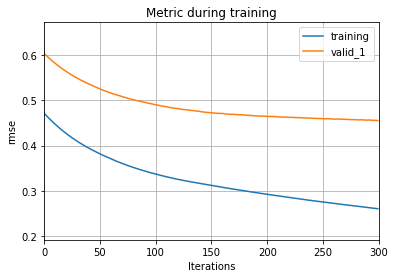

Plotting feature importances...


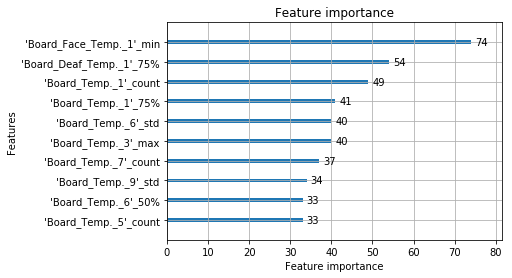

Plotting 54th tree...


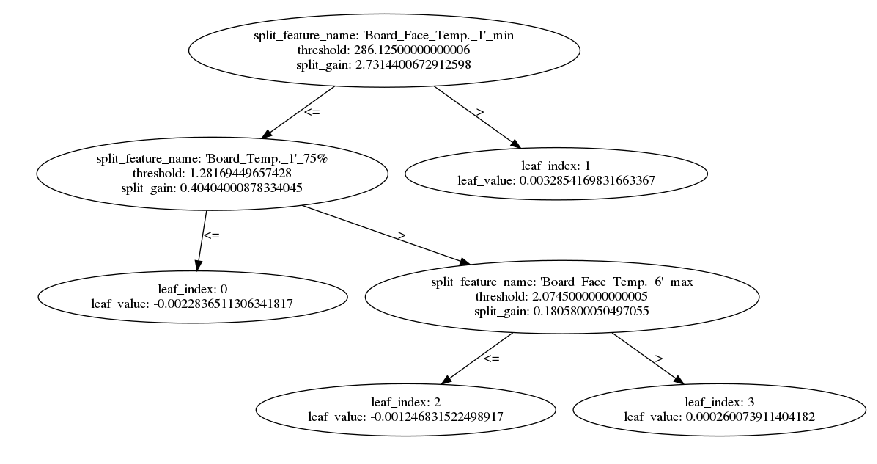

Plotting 54th tree with graphviz...


'Tree54.gv.pdf'

In [50]:
evals_result = {}  # to record eval results for plotting

print('Starting training...')
# train

params = {
    'learning_rate': 0.01134967265153673, 
    'max_depth': 5, 
    'n_estimators': 300, 
    'num_leaves': 20, 
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
#                 feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                feature_name=col,
                evals_result=evals_result,
                verbose_eval=10)

print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

print('Plotting 54th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm, tree_index=53, figsize=(15, 15), show_info=['split_gain'])
plt.show()

print('Plotting 54th tree with graphviz...')
graph = lgb.create_tree_digraph(gbm, tree_index=53, name='Tree54')
graph.render(view=True)

**Validation curves don't converge. The relationship between the training and validation error, and the gap can be summarized this way: So the bigger the difference between the two errors, the bigger the gap. The bigger the gap, the bigger the variance. In our case, the gap is very big, so we can safely conclude that the variance is high and MSE scores training is low.**


In [205]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

In [206]:
ls = Lasso()
ls_cv = GridSearchCV(ls, lasso_params, cv=3)
ls_cv.fit(X_train, y_train)

print('Best parameters found by grid search for Lasso are:', ls_cv.best_params_)

Best parameters found by grid search for Lasso are: {'alpha': 0.02}


0.08718616526043907


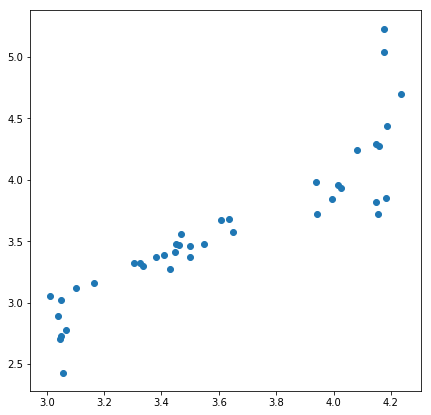

In [195]:
gbm = LGBMRegressor(    learning_rate=0.01134967265153673, 
    max_depth=5, 
    n_estimators=300, 
    num_leaves=20, 
    objective='regression',
    metric='rmse',
    verbose=0)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_val)
print(mean_squared_error(y_pred, y_val))
plt.figure(figsize=[7,7])
plt.scatter(y_pred, y_val)

0.01669816554050005


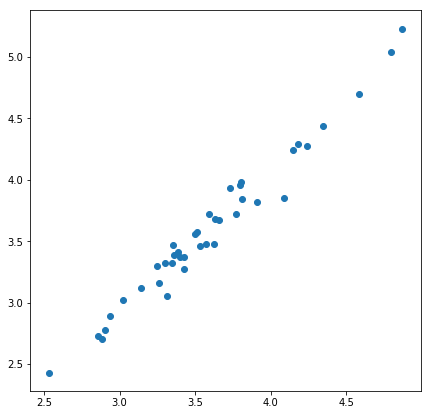

In [207]:
ls = Lasso(alpha=0.02)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_val)
plt.figure(figsize=[7,7])
plt.scatter(y_pred, y_val)
print(mean_squared_error(y_pred, y_val))

- **simple tunning alpha make prediction impressively good**
- **due of the qualities params, lasso with regularization worked better than lgbm**
- **in future I going to work with time dependesis; maybe more data have hiht correlation such format and should work with time series**